In [1]:
import sys
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import pandas as pd

In [3]:
# df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/NonPromoterSequence.txt', sep = '>', )
# df.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
# df.reset_index(inplace = True)
# df.drop(['EP 1 (+) mt:CoI_1; range -400 to -100.', 'index'], axis = 1, inplace=True) #data cleaning after error found
# df.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
# df['label'] = 0

# df2 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PromoterSequence.txt', sep = '>', )
# df2.dropna(subset=['Unnamed: 0'], how='all', inplace=True)
# df2.reset_index(inplace = True)
# df2.drop(['EP 1 (+) mt:CoI_1; range -100 to 200.', 'index'], axis = 1, inplace=True)
# df2.rename(columns={'Unnamed: 0': "sequence"}, inplace = True)
# df2['label'] = 1

# df = pd.concat([df, df2], axis = 0 )

In [4]:
# for seq in df['sequence']:
#     if 'N' in seq:
#         display(df.loc[df['sequence'] == seq])

# df.drop([1822], inplace = True)

In [5]:

# sequence = list(df.loc[:, 'sequence'])
# encoded_seq = []

# def seq2kmer(seq, k):
#     """
#     Convert original sequence to kmers
    
#     Arguments:
#     seq -- str, original sequence.
#     k -- int, kmer of length k specified.
    
#     Returns:
#     kmers -- str, kmers separated by space
#     """
#     kmer = [seq[x:x+k] for x in range(len(seq)+1-k)]
#     kmers = " ".join(kmer)
#     return kmers

# for seq in sequence:
#   x = seq2kmer(seq, 6)
#   encoded_seq.append(x)

# print(encoded_seq[0])


In [6]:
# label = list(df.loc[:,'label'])
# new_df = pd.DataFrame(encoded_seq, columns = ['sequence'])

# new_df.insert(1, 'label', label)

# new_df.head()

In [7]:
# new_df.to_csv("dnabert_input.csv", mode='a', header=False)

In [8]:
!pip install transformers

import numpy as np
import os

import joblib
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import utils
import torch


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 17.3 MB/s 
     |████████████████████████████████| 7.6 MB 45.2 MB/s 
     |████████████████████████████████| 182 kB 37.7 MB/s 


In [9]:
df = pd.read_csv('/content/gdrive/MyDrive/dnabert_input.csv', sep = ',', )
df.columns = ['id', 'sequence', 'label']
df.drop(columns = ['id'])


,sequence,label
0,ATTTTT TTTTTA TTTTAC TTTACA TTACAA TACAAG ACAA...,0
1,AGAGAT GAGATA AGATAG GATAGG ATAGGT TAGGTG AGGT...,0
2,TATGTA ATGTAT TGTATA GTATAT TATATA ATATAG TATA...,0
3,AGAAAT GAAATA AAATAA AATAAT ATAATA TAATAG AATA...,0
4,CTTTAA TTTAAA TTAAAA TAAAAT AAAATT AAATTA AATT...,0
...,...,...
22592,CGACAA GACAAA ACAAAG CAAAGT AAAGTT AAGTTT AGTT...,1
22593,CATATC ATATCT TATCTA ATCTAC TCTACA CTACAT TACA...,1
22594,ATACCG TACCGC ACCGCG CCGCGG CGCGGA GCGGAA CGGA...,1
22595,ATTATT TTATTC TATTCC ATTCCG TTCCGA TCCGAA CCGA...,1


In [10]:
df.shape

(22597, 3)

In [11]:
# Import the necessary 
!pip install --upgrade transformers

import transformers
from transformers import AutoModel, AutoTokenizer
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
tokenizer = AutoTokenizer.from_pretrained("armheb/DNA_bert_6")

# Load your dataset

data = df

# data['sequence'] = input_sequences

# data.tail()

# Divide the dataset into train, validation, and test sets
train_data, val_data = train_test_split(
    data, 
    test_size=0.1, 
    random_state=42,
    stratify=data['label']
)
val_data, test_data = train_test_split(
    val_data, 
    test_size=0.5, 
    random_state=42,
    stratify=val_data['label']
)

device = torch.device('cuda')
use_cuda = True

train_input = tokenizer.batch_encode_plus(train_data["sequence"].tolist(), 
                                          add_special_tokens=True, 
                                          max_length=512, 
                                          pad_to_max_length=True, 
                                          return_attention_mask=True, 
                                          return_tensors = 'pt')

val_input = tokenizer.batch_encode_plus(val_data["sequence"].tolist(),
                                        add_special_tokens=True, 
                                        max_length=512, 
                                        pad_to_max_length=True, 
                                        return_attention_mask=True, 
                                        return_tensors = 'pt')

test_input = tokenizer.batch_encode_plus(test_data["sequence"].tolist(),
                                         add_special_tokens=True, 
                                         max_length=512, 
                                         pad_to_max_length=True, 
                                         return_attention_mask=True, 
                                         return_tensors = 'pt')

train_input_ids = train_input['input_ids']
train_att_masks = train_input['attention_mask']
train_labels = torch.tensor(train_data['label'].values)

val_input_ids = val_input['input_ids']
val_att_masks = val_input['attention_mask']
val_labels = torch.tensor(val_data['label'].values)

test_input_ids = test_input['input_ids']
test_att_masks = test_input['attention_mask']
test_labels = torch.tensor(test_data['label'].values)

Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [13]:
class DNABERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 # 기존 -> num_classes = 2
                 num_classes = 2, # softmax 사용(다중분류)
                 dr_rate=None,
                 params=None):
        super().__init__()
        self.bert = bert
        self.dr_rate = dr_rate
                 
        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, attention_mask):
        _, pooler = self.bert(input_ids = token_ids,
                              attention_mask = attention_mask,
                              return_dict=False)
        return self.classifier(pooler) 

In [14]:
bert = AutoModel.from_pretrained("armheb/DNA_bert_6")

model = DNABERTClassifier(bert)

if use_cuda and torch.cuda.is_available():
    model.cuda()

# Define the optimizer, loss function, and number of training epochs
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
loss_fn = torch.nn.CrossEntropyLoss(reduction='sum') 


Downloading:   0%|          | 0.00/359M [00:00<?, ?B/s]

Some weights of the model checkpoint at armheb/DNA_bert_6 were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
def metric_batch(output, target):
    pred = output.argmax(1, keepdim=True)
    corrects = pred.eq(target.view_as(pred)).sum().item()
    return corrects


# function to calculate loss per mini-batch
def loss_batch(loss_func, output, target, opt=None):
    loss = loss_func(output, target)
    metric_b = metric_batch(output, target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [16]:
loss_history = {"train": [], "val":[]}
batch_history = {'loss': [], 'accuracy': []}
accuracy_history = {"train": [], "val":[]}

train_input_size = len(train_input_ids)
val_input_size = len(val_input_ids)
epochs = 5              # (5, 16) need 3 hour in Colab Free
batch_size = 16         #if your gpu big enough, use 32

for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}')
    # Set the model to training mode
    model.train()

    epoch_loss = 0.0
    epoch_metric = 0.0

    # Loop over each batch of training data
    for i in tqdm(range(0, train_input_size, batch_size)):
        # Get the current batch of data
        batch_input_ids = train_input_ids[i:i+batch_size].to(device)
        batch_labels = train_labels[i:i+batch_size].to(device)
        batch_att_masks = train_att_masks[i:i+batch_size].to(device)
        # Forward pass
        outputs = model(batch_input_ids, batch_att_masks)

        # Compute the loss
        loss_b, metric_b = loss_batch(loss_fn, outputs, batch_labels, optimizer)

        epoch_loss += loss_b
        if metric_b is not None:
            epoch_metric += metric_b

        if i % 1600 == 0:
            print(f'batch {i / batch_size}, loss : {(loss_b/ batch_size):.4f}, accuracy : {(metric_b / batch_size):.4f}')
            batch_history['loss'].append(loss_b / batch_size)
            batch_history['accuracy'].append(metric_b / batch_size)

    epoch_loss = epoch_loss / train_input_size
    epoch_metric = epoch_metric / train_input_size

    loss_history['train'].append(epoch_loss)
    accuracy_history['train'].append(epoch_metric)
    # Set the model to evaluation mode
    model.eval()

    # Evaluate the model on the validation set
    with torch.no_grad():
        val_loss = 0.0
        val_metric = 0.0
        for i in tqdm(range(0, val_input_size, batch_size)):
            # Forward pass
            batch_input_ids = val_input_ids[i:i+batch_size].to(device)
            batch_labels = val_labels[i:i+batch_size].to(device)
            batch_att_masks = val_att_masks[i:i+batch_size].to(device)
            outputs = model(batch_input_ids, batch_att_masks)

            # Compute the loss
            loss_b, metric_b = loss_batch(loss_fn, outputs, batch_labels)
            val_loss += loss_b
            if metric_b is not None:
                val_metric += metric_b

        val_loss = val_loss / val_input_size
        val_metric = val_metric / val_input_size
        loss_history['val'].append(val_loss)
        accuracy_history['val'].append(val_metric)
        # Print the validation loss
    
        print(f'train loss {epoch_loss:.4f}, validation loss {val_loss:.4f}')
        print(f'train accuracy {epoch_metric:.4f}, validation accuracy {val_metric:.4f}')
        print('-'*30)

# Save the finetuned model
# torch.save(model.state_dict(), 'finetuned_model.pth')

Epoch 1/5


  0%|          | 1/1272 [00:04<1:37:25,  4.60s/it]

batch 0.0, loss : 0.6579, accuracy : 0.6250


  8%|▊         | 101/1272 [02:41<30:35,  1.57s/it]

batch 100.0, loss : 0.3752, accuracy : 0.8750


 16%|█▌        | 201/1272 [05:19<28:05,  1.57s/it]

batch 200.0, loss : 0.4505, accuracy : 0.7500


 24%|██▎       | 301/1272 [07:57<25:35,  1.58s/it]

batch 300.0, loss : 0.7859, accuracy : 0.4375


 32%|███▏      | 401/1272 [10:35<22:57,  1.58s/it]

batch 400.0, loss : 0.3687, accuracy : 0.7500


 39%|███▉      | 501/1272 [13:13<20:14,  1.58s/it]

batch 500.0, loss : 0.4265, accuracy : 0.8125


 47%|████▋     | 601/1272 [15:50<17:36,  1.57s/it]

batch 600.0, loss : 0.4864, accuracy : 0.7500


 55%|█████▌    | 701/1272 [18:28<14:59,  1.58s/it]

batch 700.0, loss : 0.2520, accuracy : 1.0000


 63%|██████▎   | 801/1272 [21:05<12:20,  1.57s/it]

batch 800.0, loss : 0.4669, accuracy : 0.8125


 71%|███████   | 901/1272 [23:42<09:42,  1.57s/it]

batch 900.0, loss : 0.7175, accuracy : 0.6875


 79%|███████▊  | 1001/1272 [26:20<07:06,  1.58s/it]

batch 1000.0, loss : 0.1094, accuracy : 1.0000


 87%|████████▋ | 1101/1272 [28:57<04:29,  1.58s/it]

batch 1100.0, loss : 0.4585, accuracy : 0.8125


 94%|█████████▍| 1201/1272 [31:35<01:51,  1.57s/it]

batch 1200.0, loss : 0.1726, accuracy : 0.8750


100%|██████████| 71/71 [00:41<00:00,  1.71it/s]


train loss 0.4444, validation loss 0.3164
train accuracy 0.7910, validation accuracy 0.8735
------------------------------
Epoch 2/5


  0%|          | 1/1272 [00:01<33:16,  1.57s/it]

batch 0.0, loss : 0.1213, accuracy : 1.0000


  8%|▊         | 101/1272 [02:38<30:46,  1.58s/it]

batch 100.0, loss : 0.2566, accuracy : 0.9375


 16%|█▌        | 201/1272 [05:16<28:07,  1.58s/it]

batch 200.0, loss : 0.2929, accuracy : 0.8750


 24%|██▎       | 301/1272 [07:54<25:30,  1.58s/it]

batch 300.0, loss : 0.5039, accuracy : 0.7500


 32%|███▏      | 401/1272 [10:32<22:57,  1.58s/it]

batch 400.0, loss : 0.2422, accuracy : 0.9375


 39%|███▉      | 501/1272 [13:10<20:21,  1.58s/it]

batch 500.0, loss : 0.1069, accuracy : 1.0000


 47%|████▋     | 601/1272 [15:48<17:41,  1.58s/it]

batch 600.0, loss : 0.2288, accuracy : 0.9375


 55%|█████▌    | 701/1272 [18:26<14:57,  1.57s/it]

batch 700.0, loss : 0.1666, accuracy : 0.9375


 63%|██████▎   | 801/1272 [21:04<12:26,  1.58s/it]

batch 800.0, loss : 0.2881, accuracy : 0.8750


 71%|███████   | 901/1272 [23:42<09:41,  1.57s/it]

batch 900.0, loss : 0.4496, accuracy : 0.7500


 79%|███████▊  | 1001/1272 [26:19<07:08,  1.58s/it]

batch 1000.0, loss : 0.0658, accuracy : 1.0000


 87%|████████▋ | 1101/1272 [28:57<04:28,  1.57s/it]

batch 1100.0, loss : 0.6666, accuracy : 0.7500


 94%|█████████▍| 1201/1272 [31:34<01:52,  1.58s/it]

batch 1200.0, loss : 0.1060, accuracy : 0.9375


100%|██████████| 71/71 [00:41<00:00,  1.70it/s]


train loss 0.2747, validation loss 0.2468
train accuracy 0.8874, validation accuracy 0.9035
------------------------------
Epoch 3/5


  0%|          | 1/1272 [00:01<33:12,  1.57s/it]

batch 0.0, loss : 0.1125, accuracy : 0.9375


  8%|▊         | 101/1272 [02:39<30:37,  1.57s/it]

batch 100.0, loss : 0.0778, accuracy : 0.9375


 16%|█▌        | 201/1272 [05:16<28:00,  1.57s/it]

batch 200.0, loss : 0.2305, accuracy : 0.8125


 24%|██▎       | 301/1272 [07:53<25:36,  1.58s/it]

batch 300.0, loss : 0.3649, accuracy : 0.8125


 32%|███▏      | 401/1272 [10:31<22:50,  1.57s/it]

batch 400.0, loss : 0.1705, accuracy : 0.9375


 39%|███▉      | 501/1272 [13:08<20:16,  1.58s/it]

batch 500.0, loss : 0.0496, accuracy : 1.0000


 47%|████▋     | 601/1272 [15:47<17:41,  1.58s/it]

batch 600.0, loss : 0.1610, accuracy : 0.9375


 55%|█████▌    | 701/1272 [18:24<14:56,  1.57s/it]

batch 700.0, loss : 0.1387, accuracy : 1.0000


 63%|██████▎   | 801/1272 [21:02<12:20,  1.57s/it]

batch 800.0, loss : 0.1329, accuracy : 0.9375


 71%|███████   | 901/1272 [23:39<09:43,  1.57s/it]

batch 900.0, loss : 0.1847, accuracy : 0.8750


 79%|███████▊  | 1001/1272 [26:16<07:05,  1.57s/it]

batch 1000.0, loss : 0.0265, accuracy : 1.0000


 87%|████████▋ | 1101/1272 [28:54<04:28,  1.57s/it]

batch 1100.0, loss : 0.3879, accuracy : 0.9375


 94%|█████████▍| 1201/1272 [31:31<01:52,  1.58s/it]

batch 1200.0, loss : 0.0185, accuracy : 1.0000


100%|██████████| 71/71 [00:41<00:00,  1.71it/s]


train loss 0.1882, validation loss 0.2587
train accuracy 0.9302, validation accuracy 0.9009
------------------------------
Epoch 4/5


  0%|          | 1/1272 [00:01<33:19,  1.57s/it]

batch 0.0, loss : 0.1249, accuracy : 1.0000


  8%|▊         | 101/1272 [02:39<30:53,  1.58s/it]

batch 100.0, loss : 0.0987, accuracy : 0.9375


 16%|█▌        | 201/1272 [05:17<28:10,  1.58s/it]

batch 200.0, loss : 0.1473, accuracy : 0.8750


 24%|██▎       | 301/1272 [07:55<25:29,  1.58s/it]

batch 300.0, loss : 0.2368, accuracy : 0.9375


 32%|███▏      | 401/1272 [10:32<22:55,  1.58s/it]

batch 400.0, loss : 0.1585, accuracy : 0.9375


 39%|███▉      | 501/1272 [13:10<20:17,  1.58s/it]

batch 500.0, loss : 0.0114, accuracy : 1.0000


 47%|████▋     | 601/1272 [15:48<17:39,  1.58s/it]

batch 600.0, loss : 0.0163, accuracy : 1.0000


 55%|█████▌    | 701/1272 [18:26<15:01,  1.58s/it]

batch 700.0, loss : 0.1043, accuracy : 0.9375


 63%|██████▎   | 801/1272 [21:04<12:25,  1.58s/it]

batch 800.0, loss : 0.0640, accuracy : 1.0000


 71%|███████   | 901/1272 [23:41<09:44,  1.58s/it]

batch 900.0, loss : 0.0310, accuracy : 1.0000


 79%|███████▊  | 1001/1272 [26:19<07:07,  1.58s/it]

batch 1000.0, loss : 0.0088, accuracy : 1.0000


 87%|████████▋ | 1101/1272 [28:57<04:30,  1.58s/it]

batch 1100.0, loss : 0.1541, accuracy : 0.9375


 94%|█████████▍| 1201/1272 [31:35<01:51,  1.58s/it]

batch 1200.0, loss : 0.0503, accuracy : 1.0000


100%|██████████| 71/71 [00:41<00:00,  1.70it/s]


train loss 0.1328, validation loss 0.3327
train accuracy 0.9525, validation accuracy 0.8876
------------------------------
Epoch 5/5


  0%|          | 1/1272 [00:01<33:23,  1.58s/it]

batch 0.0, loss : 0.1262, accuracy : 0.9375


  8%|▊         | 101/1272 [02:39<30:53,  1.58s/it]

batch 100.0, loss : 0.0473, accuracy : 1.0000


 16%|█▌        | 201/1272 [05:18<28:04,  1.57s/it]

batch 200.0, loss : 0.0361, accuracy : 1.0000


 24%|██▎       | 301/1272 [07:55<25:31,  1.58s/it]

batch 300.0, loss : 0.0398, accuracy : 1.0000


 32%|███▏      | 401/1272 [10:33<22:58,  1.58s/it]

batch 400.0, loss : 0.0507, accuracy : 1.0000


 39%|███▉      | 501/1272 [13:10<20:11,  1.57s/it]

batch 500.0, loss : 0.0430, accuracy : 1.0000


 47%|████▋     | 601/1272 [15:48<17:34,  1.57s/it]

batch 600.0, loss : 0.2155, accuracy : 0.9375


 55%|█████▌    | 701/1272 [18:25<15:00,  1.58s/it]

batch 700.0, loss : 0.0133, accuracy : 1.0000


 63%|██████▎   | 801/1272 [21:03<12:26,  1.58s/it]

batch 800.0, loss : 0.0240, accuracy : 1.0000


 71%|███████   | 901/1272 [23:42<09:48,  1.59s/it]

batch 900.0, loss : 0.0514, accuracy : 1.0000


 79%|███████▊  | 1001/1272 [26:20<07:07,  1.58s/it]

batch 1000.0, loss : 0.0158, accuracy : 1.0000


 87%|████████▋ | 1101/1272 [28:58<04:30,  1.58s/it]

batch 1100.0, loss : 0.2062, accuracy : 0.9375


 94%|█████████▍| 1201/1272 [31:35<01:51,  1.57s/it]

batch 1200.0, loss : 0.0235, accuracy : 1.0000


100%|██████████| 71/71 [00:41<00:00,  1.71it/s]

train loss 0.0953, validation loss 0.3131
train accuracy 0.9672, validation accuracy 0.9035
------------------------------


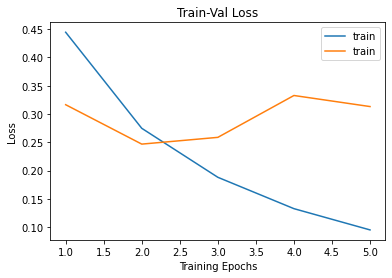

In [17]:
from torchvision import utils
import matplotlib.pyplot as plt

plt.title("Train-Val Loss")
plt.plot(range(1,epochs+1),loss_history["train"], label='train')
plt.plot(range(1,epochs+1),loss_history["val"], label='train')
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()


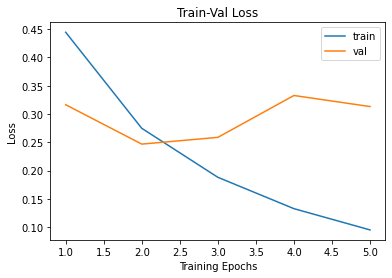

In [18]:
plt.title("Train-Val Loss")
plt.plot(range(1,epochs+1),loss_history["train"], label='train')
plt.plot(range(1,epochs+1),loss_history["val"], label='val')
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.savefig('dnabert+1classifier loss')

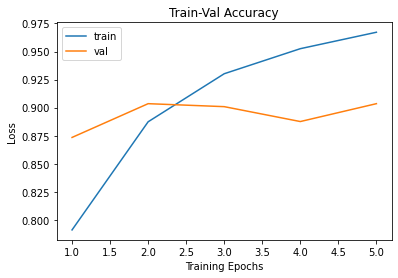

In [19]:
plt.title("Train-Val Accuracy")
plt.plot(range(1,epochs+1),accuracy_history["train"], label='train')
plt.plot(range(1,epochs+1),accuracy_history["val"], label='val')
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.savefig('dnabert+1classifier metric')

In [20]:
output_list = []
test_input_size = len(test_input_ids)

with torch.no_grad():
    for i in tqdm(range(0, test_input_size, batch_size)):
        # Forward pass
        batch_input_ids = test_input_ids[i:i+batch_size].to(device)
        batch_labels = test_labels[i:i+batch_size].to(device)
        batch_att_masks = test_att_masks[i:i+batch_size].to(device)
        outputs = model(batch_input_ids, batch_att_masks)
        pred = outputs.argmax(1, keepdim=True)
        output_list.append(pred)

pred = torch.cat(output_list, 0)
print(pred)

100%|██████████| 71/71 [00:41<00:00,  1.72it/s]


tensor([[1],
        [1],
        [0],
        ...,
        [0],
        [1],
        [1]], device='cuda:0')


In [21]:
print(len(test_labels))
print(len(pred))

1130
1130


In [24]:
pred_np = pred.cpu().numpy()
np.save('test_output', pred_np)

test_label_np = test_labels.numpy()
np.save('test_labels', test_label_np)

print(pred_np)
print(test_label_np)

[[1]
 [1]
 [0]
 ...
 [0]
 [1]
 [1]]
[1 1 0 ... 0 1 1]


In [28]:
tn = 0
fn = 0
fp = 0
tp = 0

for i in range(len(pred_np)):
  if(pred_np[i] == 0): # non-promoter
    if test_label_np[i] == 0:
      tn += 1
    else:
      fn += 1
  else:                          # promoter
    if test_label_np[i] == 1:
      tp += 1
    else:
      fp += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
accuracy = (tp + tn) / (tp + fn + fp + tn)
print(precision, recall, accuracy)
print(tp, fn, fp, tn)

0.840625 0.952212389380531 0.8858407079646018
538 27 102 463


In [31]:
!pip install torchinfo
from torchinfo import summary

summary(model)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Layer (type:depth-idx)                                  Param #
DNABERTClassifier                                       --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              3,149,568
│    │    └─Embedding: 3-2                              393,216
│    │    └─Embedding: 3-3                              1,536
│    │    └─LayerNorm: 3-4                              1,536
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             85,054,464
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 590,592
│    │    └─Tanh: 3-8                                   --
├─Linear: 1-2                                           1,538
Total params: 89,192,450
Trainable params: 89,192,450
Non-trainable params: 

In [32]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/finetuned_model.pth')